In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

from time import sleep

import quandl

import seaborn as sns

import sys
from scipy.stats import norm
import ezodf
import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def wrangle(assets, data_freq, lookback_period):
    data = pd.concat(assets, axis = 1)
    data = data.ffill()
    data = data.dropna()
    data = data/data.shift()
    data = data.fillna(1)
    data = data.ffill()
    if data_freq == 'M':
        data = data[-lookback_period*12:]
    elif data_freq == 'D':
        data = data[-lookback_period*252:]
        
    data_names = data.columns.tolist() 
        
    return (data, data_names)

In [3]:
def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)

In [4]:
def strategy_evaluation(result, data_names, lookback_period, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], lookback_period, freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], lookback_period, freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '20px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino','SWR', 'Skew'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Kurtosis'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.0%}", 'Volatility': "{:.1%}", 'SWR':"{:.1%}", 'Sharpe': "{:.2f}",
              'Sortino': "{:.2f}", 'MAR': "{:.2f}"})
      .set_table_styles(styles))
    
    return metrics



In [5]:
def port_eval(port, lookback_period, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    
    skew = round(pd.DataFrame(scipy.stats.skew(port_ret)),3)
    kurtosis = round(pd.DataFrame(scipy.stats.kurtosis(port_ret)),3)
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),3)
        sortino = round((cagr)/sortino,3)
        sharpe = round((cagr)/vol,3)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round((cagr)/sortino,2)
        sharpe = round((cagr)/vol,2)                   
                       
    SWR = round(MAX_SWR(cagr, vol, 30), 4)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(SWR.iloc[0]), float(skew.iloc[0]), float(kurtosis.iloc[0])]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'SWR', 'Skew', 'Kurtosis'])
    

    
    return metrics

In [6]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

def MAX_SWR(CAGR, VOL, T):
    MAX_SWR = CAGR - (1.96*VOL*np.sqrt(T))/T
    
    return MAX_SWR

def rf(lookback_period):
    
    data_freq = 'M' 
    rebalance_freq = 12 
    tol = 0.1 
    assets = [T_Bill] 
    leverage = 1
    w = [1]
    
    data, data_names = wrangle(assets, data_freq, lookback_period)

    res, weights = backtest_strategy(data, w, tol, rebalance_freq, data_names, leverage)
    
    port = pd.DataFrame(res['3 Month T-Bill'])
    port_ret = calc_port_ret(res['3 Month T-Bill'])
    
    riskfree_rate = float(round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4))
    
    return riskfree_rate

In [7]:
def plot(result, scale):
    sns.set_style("darkgrid");
    plt.figure(figsize=(20,10));
    for i in result.columns:
        plt.plot(result[i], label = i);

    start = datetime.date(result.index.min());
    end = datetime.date(result.index.max());
    if scale == "log":
        plt.yscale("log")
        plt.ylabel('Log Return', fontsize=18)
    else: 
        plt.ylabel('Linear Return', fontsize=18)
    plt.legend(loc=2, prop={'size': 20});
    plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)

### Backtest function

In [8]:
def dynamic_backtest(data, lookback,rebalance_freq,tol,leverage,w_scheme = risk_parity):

    i= 0
    W= w_scheme(data[i:i+lookback])
    wealth = 1
    asset = [i * wealth for i in W]
    port = []
    port_W = []


    cut_data = data[lookback:]

    if 0.999 < sum(W) < 1.001:


        for i in range(len(cut_data)):
            #port.append(initial)
            port_W.append([i / wealth for i in asset])
            
            daily_ret = ((cut_data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret 
            wealth = sum(asset)
            port.append(wealth)
        
            #Rebalancing by days
            if i%rebalance_freq == 0:
                W= w_scheme(data[i:i+36]) #Make it possible for different weightings
                for i in range(len(W)):
                    asset[i] = wealth * W[i]
                
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/wealth - W[i])> tol: 
                        W= w_scheme(data[i:i+36]) #Make it possible for different weightings
                       
                        asset = [i * wealth for i in W]
    
        port = pd.DataFrame(port)
        port.index = cut_data.index
    
        result = pd.concat([port, cut_data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
            
        #return (result, port_W)
            
    else:
        print("Weight not Equal to 1!")
        
    return result

### Optimazation Functions

In [9]:
def Optimize_Portfolio(data ,risk_free = 0, objective = 'Kelly'):
    

    #cov_fit = LedoitWolf().fit(data)
    #cov = cov_fit.covariance_
    
    if objective == 'Kelly':  
        #ret = (data).prod()**(1/len(data)) - 1 #cagr
        ret = (data-1).mean()
        cov = data.cov().to_numpy()
        #need smaller step size
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                      {'type':'ineq', 'fun': lambda x: 1 - np.sum(x)}) # sum <= 1
                      #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        
        
        result = sco.minimize(kelly_objective, num_assets*[1./num_assets,], args=args, 
                                  method='SLSQP', constraints=constraints) 
        
    elif objective == 'Sharpe':
        ret = (data-1).mean() 
        cov = data.cov().to_numpy()
        
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        result = sco.minimize(sharpe_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints)
    elif objective == 'Max Div':
        ret = (data-1).mean() 
        cov = data.cov().to_numpy()
        
        num_assets = ret.shape[0]
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        result = sco.minimize(calc_diversification_ratio, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints)
        
    
        
    
    return (result)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)


In [10]:
def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def equal_weight(data):
    num_assets = len(data.columns)
    weight = num_assets*[1./num_assets,]
    
    return(weight)

In [11]:
def calc_diversification_ratio(w, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), w.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(w, cov))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def max_div(data):   
    cov = np.array(data.cov())
    
    #cov_fit = LedoitWolf().fit(data)
    #cov = cov_fit.covariance_
    
    num_assets = data.shape[1]
    args = (cov)
    constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
    
    result = sco.minimize(calc_diversification_ratio,num_assets*[1./num_assets,], args=args, 
                            method='SLSQP', constraints=constraints) 
    
    return result.x

# Dynamic Backtest

- Risk Parity
- Mean-Variance
- Tail risk Parity

In [12]:
%run backtest_data.ipynb

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
lookback_period = 60 # in years
data_freq = 'M' # 'M' for monthly, 'D' for daily
rebalance_freq = 12 # in monthy for monthtly, days for daily
tol = 1 # trigger for rebalancing
lookback = 36 # for covariance matrix
assets = [USA_monthly, Gold_monthly,Ret_bond_10YR] 
leverage = 1
data, data_names = wrangle(assets, data_freq, lookback_period)


In [21]:
result = dynamic_backtest(data, lookback,rebalance_freq,tol,leverage,w_scheme = equal_weight)

Weight not Equal to 1!


UnboundLocalError: local variable 'result' referenced before assignment

In [19]:
strategy_evaluation(result, data_names, lookback_period, freq = data_freq)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,SWR,Skew,Kurtosis
Portfolio,8.3%,9.0%,0.92,1.38,-19%,0.43,5.1%,0.288000,3.230000
USA,9.7%,15.1%,0.64,0.81,-51%,0.19,4.3%,-0.398000,2.061000
Gold,7.1%,19.7%,0.36,0.59,-62%,0.11,0.0%,0.927000,4.547000
Bond 10 Yr,4.7%,7.2%,0.65,0.93,-15%,0.31,2.1%,1.060000,6.061000


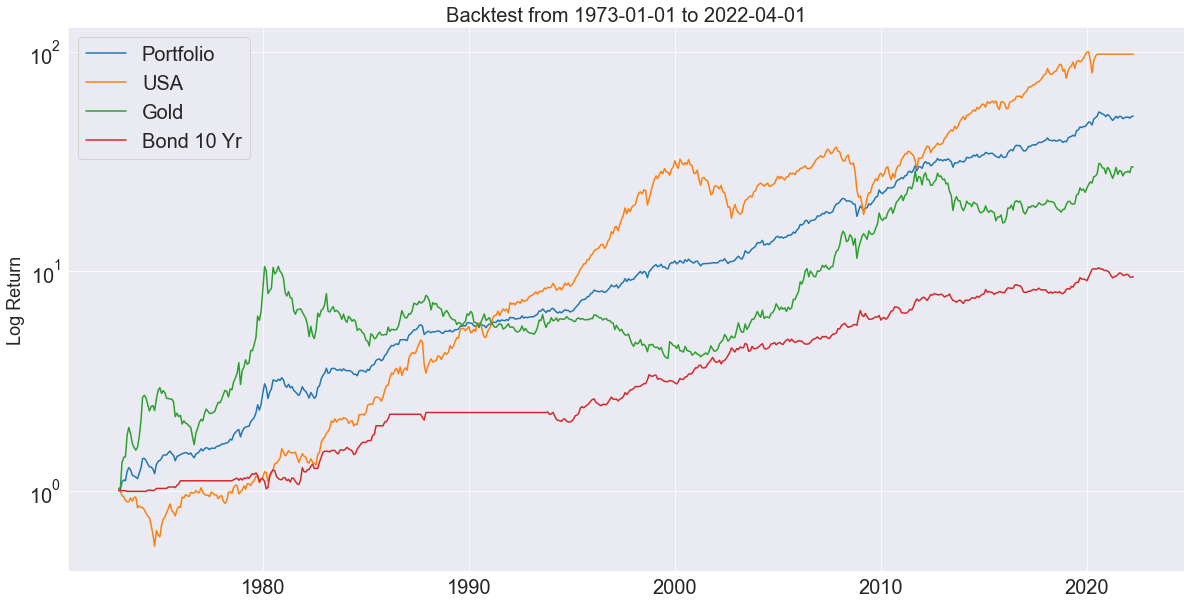

In [20]:
plot(result, "log")

In [31]:
result = Optimize_Portfolio(data, objective='Max Div')
result['x'].round(2)

array([0.17, 0.14, 0.63, 0.06])